# Can we Determine the Variables that Influence Confirmed Disposition of Exoplanets?

In [13]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import io
from scipy import misc
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals.six import StringIO
from sklearn.linear_model import LogisticRegression

from sklearn.tree import export_graphviz

## Find and View Data:

Data: NASA Kepler Objects of Interest Data Set
 
A Kepler object of interest (KOI) is a star observed by the Kepler space telescope that is suspected of hosting one or more transiting planets

exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html#pdisposition

In [14]:
#load data
data = pd.read_csv('cumulative_2020.07.07_13.36.50.csv')
data.head()

kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
0      1.000              0              0              0              0   
1      0.969              0              0              0              0   
2      0.000              0              0              0              0   
3      0.000              0              1              0              0   
4      1.000              0              0              0              0   

      ...      koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  \
0     ...               -81.0      4.467           0.064          -0.096   
1     ...               -81.0      4.467           0.064          -0.096   
2     ...              -176.0      4.544           0.044          -0.176   
3     ...              -174.0      4.564           0.053          -0.168   
4     ...              -211.0      4.438           0.070          -0.210   

   koi_srad  koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0     0.927          0.105         -0.061  291.93423  48.141651      15.347  
1     0.927          0.105         -0.061  291.93423  48.141651      15.347  
2     0.868          0.233         -0.078  297.00482  48.134129      15.436  
3     0.791          0.201         -0.067  285.53461  48.285210      15.597  
4     1.046          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 49 columns]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
kepid                9564 non-null int64
kepoi_name           9564 non-null object
kepler_name          2308 non-null object
koi_disposition      9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_period           9564 non-null float64
koi_period_err1      9110 non-null float64
koi_period_err2      9110 non-null float64
koi_time0bk          9564 non-null float64
koi_time0bk_err1     9110 non-null float64
koi_time0bk_err2     9110 non-null float64
koi_impact           9201 non-null float64
koi_impact_err1      9110 non-null float64
koi_impact_err2      9110 non-null float64
koi_duration         9564 non-null float64
koi_duration_err1    9110 non-null float64
koi_

##Wrangle Data

In [16]:
#make dummy variable for our target
data = pd.get_dummies(data, columns = ['koi_disposition'])
data = data.rename(columns ={"koi_disposition_CONFIRMED":"Confirmed"})
data = data.rename(columns ={"koi_disposition_CANDIDATE":"Candidate"})
data.head()

kepid kepoi_name   kepler_name koi_pdisposition  koi_score  \
0  10797460  K00752.01  Kepler-227 b        CANDIDATE      1.000   
1  10797460  K00752.02  Kepler-227 c        CANDIDATE      0.969   
2  10811496  K00753.01           NaN        CANDIDATE      0.000   
3  10848459  K00754.01           NaN   FALSE POSITIVE      0.000   
4  10854555  K00755.01  Kepler-664 b        CANDIDATE      1.000   

   koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  \
0              0              0              0              0    9.488036   
1              0              0              0              0   54.418383   
2              0              0              0              0   19.899140   
3              0              1              0              0    1.736952   
4              0              0              0              0    2.525592   

                ...                koi_slogg_err2  koi_srad  koi_srad_err1  \
0               ...                        -0.096     0.927          0.105   
1               ...                        -0.096     0.927          0.105   
2               ...                        -0.176     0.868          0.233   
3               ...                        -0.168     0.791          0.201   
4               ...                        -0.210     1.046          0.334   

   koi_srad_err2         ra        dec  koi_kepmag  Candidate  Confirmed  \
0         -0.061  291.93423  48.141651      15.347          0          1   
1         -0.061  291.93423  48.141651      15.347          0          1   
2         -0.078  297.00482  48.134129      15.436          1          0   
3         -0.067  285.53461  48.285210      15.597          0          0   
4         -0.133  288.75488  48.226200      15.509          0          1   

   koi_disposition_FALSE POSITIVE  
0                               0  
1                               0  
2                               0  
3                               1  
4                               0  

[5 rows x 51 columns]

In [17]:
#remove candidate rows
dat = data[data['Candidate']==0]

In [18]:
dat.shape

(7146, 51)

In [19]:
#look at % missing null values
dat.isnull().sum()/len(dat)*100

kepid                               0.000000
kepoi_name                          0.000000
kepler_name                        67.702211
koi_pdisposition                    0.000000
koi_score                          12.678421
koi_fpflag_nt                       0.000000
koi_fpflag_ss                       0.000000
koi_fpflag_co                       0.000000
koi_fpflag_ec                       0.000000
koi_period                          0.000000
koi_period_err1                     4.673943
koi_period_err2                     4.673943
koi_time0bk                         0.000000
koi_time0bk_err1                    4.673943
koi_time0bk_err2                    4.673943
koi_impact                          3.610411
koi_impact_err1                     4.673943
koi_impact_err2                     4.673943
koi_duration                        0.000000
koi_duration_err1                   4.673943
koi_duration_err2                   4.673943
koi_depth                           3.610411
koi_depth_

In [20]:
# use numeric data not pertaining to flag, err or score 
# the above varaibles are the only NASA used to determain 'Confirmed'
# we want to see if we can determine confirmed with the other data
# remove columns with missing values over 20%
df = dat[['Confirmed','koi_kepmag','dec','ra','koi_srad','koi_slogg','koi_steff','koi_model_snr','koi_insol','koi_teq','koi_prad','koi_depth','koi_duration','koi_impact','koi_time0bk','koi_period']]
df.head()

Confirmed  koi_kepmag        dec         ra  koi_srad  koi_slogg  \
0          1      15.347  48.141651  291.93423     0.927      4.467   
1          1      15.347  48.141651  291.93423     0.927      4.467   
3          0      15.597  48.285210  285.53461     0.791      4.564   
4          1      15.509  48.226200  288.75488     1.046      4.438   
5          1      15.714  48.224670  296.28613     0.972      4.486   

   koi_steff  koi_model_snr  koi_insol  koi_teq  koi_prad  koi_depth  \
0     5455.0           35.8      93.59    793.0      2.26      616.0   
1     5455.0           25.8       9.11    443.0      2.83      875.0   
3     5805.0          505.6     891.96   1395.0     33.46     8080.0   
4     6031.0           40.9     926.16   1406.0      2.75      603.0   
5     6046.0           66.5     114.81    835.0      3.90     1520.0   

   koi_duration  koi_impact  koi_time0bk  koi_period  
0       2.95750       0.146   170.538750    9.488036  
1       4.50700       0.586   162.513840   54.418383  
3       2.40641       1.276   170.307565    1.736952  
4       1.65450       0.701   171.595550    2.525592  
5       4.59450       0.538   171.201160   11.094321

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7146 entries, 0 to 9563
Data columns (total 16 columns):
Confirmed        7146 non-null uint8
koi_kepmag       7145 non-null float64
dec              7146 non-null float64
ra               7146 non-null float64
koi_srad         6888 non-null float64
koi_slogg        6888 non-null float64
koi_steff        6888 non-null float64
koi_model_snr    6888 non-null float64
koi_insol        6927 non-null float64
koi_teq          6888 non-null float64
koi_prad         6888 non-null float64
koi_depth        6888 non-null float64
koi_duration     7146 non-null float64
koi_impact       6888 non-null float64
koi_time0bk      7146 non-null float64
koi_period       7146 non-null float64
dtypes: float64(15), uint8(1)
memory usage: 900.2 KB


In [22]:
#replace null values
for i in df.columns :
    if type(df[i][1]) == np.int64 :
        avg = df[i].astype('int').mean(axis=0)
        df[i].replace(np.nan, avg, inplace=True)
    elif type(df[i][1]) == np.float64:
        avg = df[i].astype('float').mean(axis=0)
        df[i].replace(np.nan, avg, inplace=True)
    else:
        pass

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7146 entries, 0 to 9563
Data columns (total 16 columns):
Confirmed        7146 non-null uint8
koi_kepmag       7146 non-null float64
dec              7146 non-null float64
ra               7146 non-null float64
koi_srad         7146 non-null float64
koi_slogg        7146 non-null float64
koi_steff        7146 non-null float64
koi_model_snr    7146 non-null float64
koi_insol        7146 non-null float64
koi_teq          7146 non-null float64
koi_prad         7146 non-null float64
koi_depth        7146 non-null float64
koi_duration     7146 non-null float64
koi_impact       7146 non-null float64
koi_time0bk      7146 non-null float64
koi_period       7146 non-null float64
dtypes: float64(15), uint8(1)
memory usage: 1.2 MB


##Examine Variables

In [24]:
#look at variance of variables
df.var()

Confirmed        2.185946e-01
koi_kepmag       1.993756e+00
dec              1.274531e+01
ra               2.258660e+01
koi_srad         4.037732e+01
koi_slogg        1.924511e-01
koi_steff        6.613143e+05
koi_model_snr    7.903372e+05
koi_insol        3.272219e+10
koi_teq          8.170571e+05
koi_prad         1.036964e+07
koi_depth        8.466731e+09
koi_duration     4.875803e+01
koi_impact       1.046238e+01
koi_time0bk      4.072422e+03
koi_period       1.297291e+04
dtype: float64

In [25]:
#get low variance variables
#could remove these later to reduce dimensionality
target = df['Confirmed']
numeric = df.drop(columns='Confirmed')
var = numeric.var()
numeric = numeric.columns
variable = [ ]
for i in range(0,len(var)-1):
    if var[i]>=1:   
       variable.append(numeric[i])

In [26]:
variable

['koi_kepmag',
 'dec',
 'ra',
 'koi_srad',
 'koi_steff',
 'koi_model_snr',
 'koi_insol',
 'koi_teq',
 'koi_prad',
 'koi_depth',
 'koi_duration',
 'koi_impact',
 'koi_time0bk']

In [27]:
#look at correlations
d = df.drop(columns='Confirmed')
cor = d.corr()
cor

koi_kepmag       dec        ra  koi_srad  koi_slogg  koi_steff  \
koi_kepmag       1.000000  0.019343 -0.003774 -0.167432   0.458354  -0.316073   
dec              0.019343  1.000000 -0.008342 -0.027745   0.056420  -0.022297   
ra              -0.003774 -0.008342  1.000000  0.056984  -0.092861   0.108939   
koi_srad        -0.167432 -0.027745  0.056984  1.000000  -0.650933  -0.124206   
koi_slogg        0.458354  0.056420 -0.092861 -0.650933   1.000000  -0.126960   
koi_steff       -0.316073 -0.022297  0.108939 -0.124206  -0.126960   1.000000   
koi_model_snr   -0.121788  0.004168  0.036769 -0.014585  -0.047478   0.151530   
koi_insol       -0.075080 -0.015382  0.029599  0.579243  -0.315194  -0.066178   
koi_teq         -0.262190 -0.056365  0.135015  0.485279  -0.567762   0.244907   
koi_prad        -0.021157 -0.003616  0.003482  0.058437  -0.096023  -0.013311   
koi_depth        0.051990 -0.014103  0.026162 -0.021893  -0.005716   0.120185   
koi_duration    -0.097122 -0.028712  0.036842  0.007743  -0.112797   0.088089   
koi_impact      -0.008757 -0.011718  0.012769  0.021813  -0.054028   0.018618   
koi_time0bk      0.010347 -0.015322 -0.048609 -0.012081   0.006059   0.004846   
koi_period      -0.038878 -0.003239 -0.068232 -0.000793  -0.035337   0.024346   

               koi_model_snr  koi_insol   koi_teq  koi_prad  koi_depth  \
koi_kepmag         -0.121788  -0.075080 -0.262190 -0.021157   0.051990   
dec                 0.004168  -0.015382 -0.056365 -0.003616  -0.014103   
ra                  0.036769   0.029599  0.135015  0.003482   0.026162   
koi_srad           -0.014585   0.579243  0.485279  0.058437  -0.021893   
koi_slogg          -0.047478  -0.315194 -0.567762 -0.096023  -0.005716   
koi_steff           0.151530  -0.066178  0.244907 -0.013311   0.120185   
koi_model_snr       1.000000  -0.012457  0.017578 -0.002562   0.568856   
koi_insol          -0.012457   1.000000  0.443474  0.003154  -0.010282   
koi_teq             0.017578   0.443474  1.000000 -0.002390   0.056693   
koi_prad           -0.002562   0.003154 -0.002390  1.000000   0.002030   
koi_depth           0.568856  -0.010282  0.056693  0.002030   1.000000   
koi_duration        0.079955  -0.020958 -0.190722  0.042690   0.062677   
koi_impact         -0.004479  -0.004820 -0.016436  0.679805   0.002787   
koi_time0bk        -0.053807  -0.023045 -0.303542  0.040525  -0.045881   
koi_period         -0.064201  -0.023217 -0.371265  0.074320  -0.062539   

               koi_duration  koi_impact  koi_time0bk  koi_period  
koi_kepmag        -0.097122   -0.008757     0.010347   -0.038878  
dec               -0.028712   -0.011718    -0.015322   -0.003239  
ra                 0.036842    0.012769    -0.048609   -0.068232  
koi_srad           0.007743    0.021813    -0.012081   -0.000793  
koi_slogg         -0.112797   -0.054028     0.006059   -0.035337  
koi_steff          0.088089    0.018618     0.004846    0.024346  
koi_model_snr      0.079955   -0.004479    -0.053807   -0.064201  
koi_insol         -0.020958   -0.004820    -0.023045   -0.023217  
koi_teq           -0.190722   -0.016436    -0.303542   -0.371265  
koi_prad           0.042690    0.679805     0.040525    0.074320  
koi_depth          0.062677    0.002787    -0.045881   -0.062539  
koi_duration       1.000000    0.047162     0.195309    0.308575  
koi_impact         0.047162    1.000000     0.061281    0.070098  
koi_time0bk        0.195309    0.061281     1.000000    0.642586  
koi_period         0.308575    0.070098     0.642586    1.000000

In [28]:
#get high correlation varaibles
#could remove these later to reduce dimensionality
cors = d.corr()
var = []
for i in cors.columns:
    for j in cors[i]:
        if  j >.5:   
           var.append([i,j])

In [29]:
var
# Correlated:
#koi_srad, koi_insol
#koi_model_snr, koi_depth
#koi_prad, koi_impact
#koi_period, koi_time0bk

[['koi_kepmag', 1.0],
 ['dec', 1.0],
 ['ra', 1.0],
 ['koi_srad', 1.0],
 ['koi_srad', 0.5792427390459053],
 ['koi_slogg', 1.0],
 ['koi_steff', 1.0],
 ['koi_model_snr', 1.0],
 ['koi_model_snr', 0.5688555529793039],
 ['koi_insol', 0.5792427390459053],
 ['koi_insol', 1.0],
 ['koi_teq', 1.0],
 ['koi_prad', 1.0],
 ['koi_prad', 0.6798050065040708],
 ['koi_depth', 0.5688555529793039],
 ['koi_depth', 1.0],
 ['koi_duration', 1.0],
 ['koi_impact', 0.6798050065040708],
 ['koi_impact', 1.0],
 ['koi_time0bk', 1.0],
 ['koi_time0bk', 0.6425860948584298],
 ['koi_period', 0.6425860948584298],
 ['koi_period', 1.0]]

In [30]:
#make training sets
X_train, X_test, y_train, y_test = train_test_split(d, target, test_size=0.2, random_state=9)

In [31]:
#do classifier to find feature importance
model = RandomForestClassifier(random_state=1, max_depth=10)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

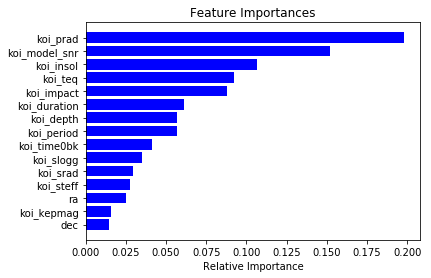

In [32]:
#plot feature importance
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##Modeling

In [33]:
#Make Decision Trees
tre3 = tree.DecisionTreeClassifier(max_depth=7)
tre3.fit(X_train,y_train)
ypred3 = tre3.predict(X_test)

In [34]:
print("Accuracy:", metrics.accuracy_score(y_test, ypred3))

Accuracy: 0.8916083916083916


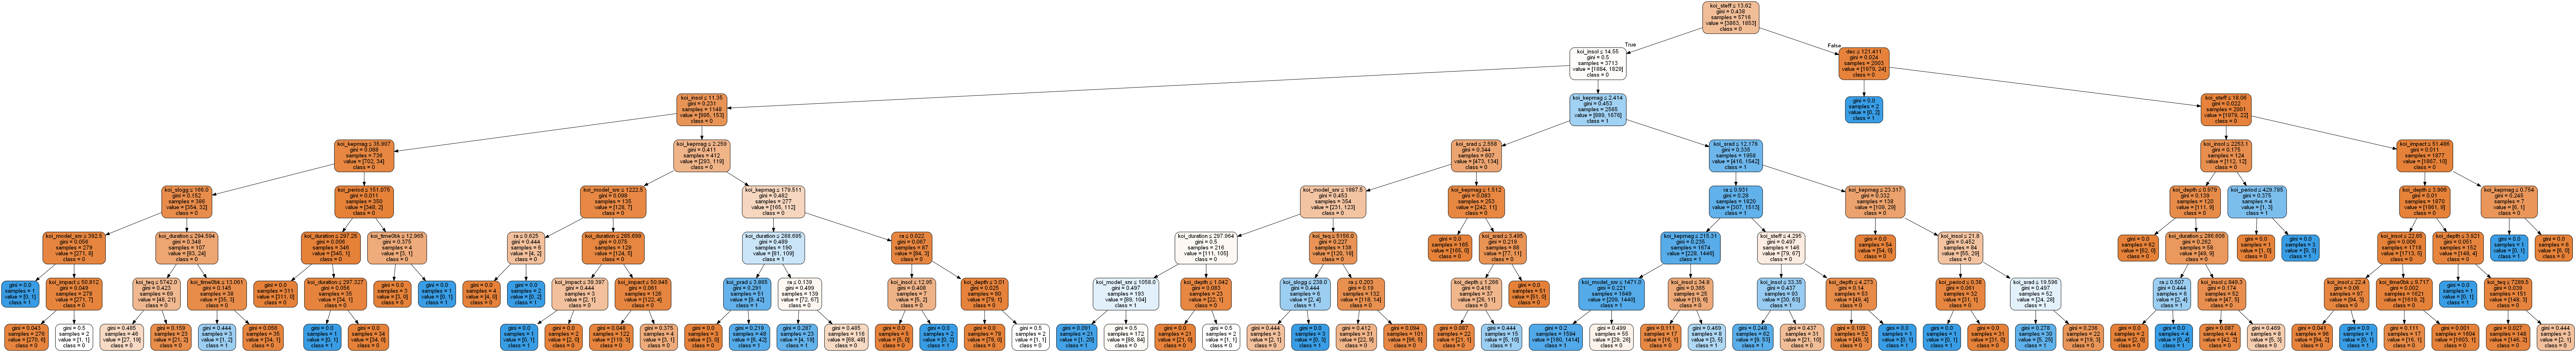

In [35]:
#Defining the feature names 
df_exo_x = ['koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 
            'koi_period', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag']
#Decision Tree Visualization
dot_data = StringIO()
export_graphviz(tre3, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = df_exo_x, class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('disposition2.png')
Image(graph.create_png())

In [36]:
tre4 = tree.DecisionTreeClassifier(max_depth=4)
tre4.fit(X_train,y_train)
ypred4 = tre4.predict(X_test)

In [37]:
print("Accuracy:", metrics.accuracy_score(y_test, ypred4))

Accuracy: 0.8685314685314686


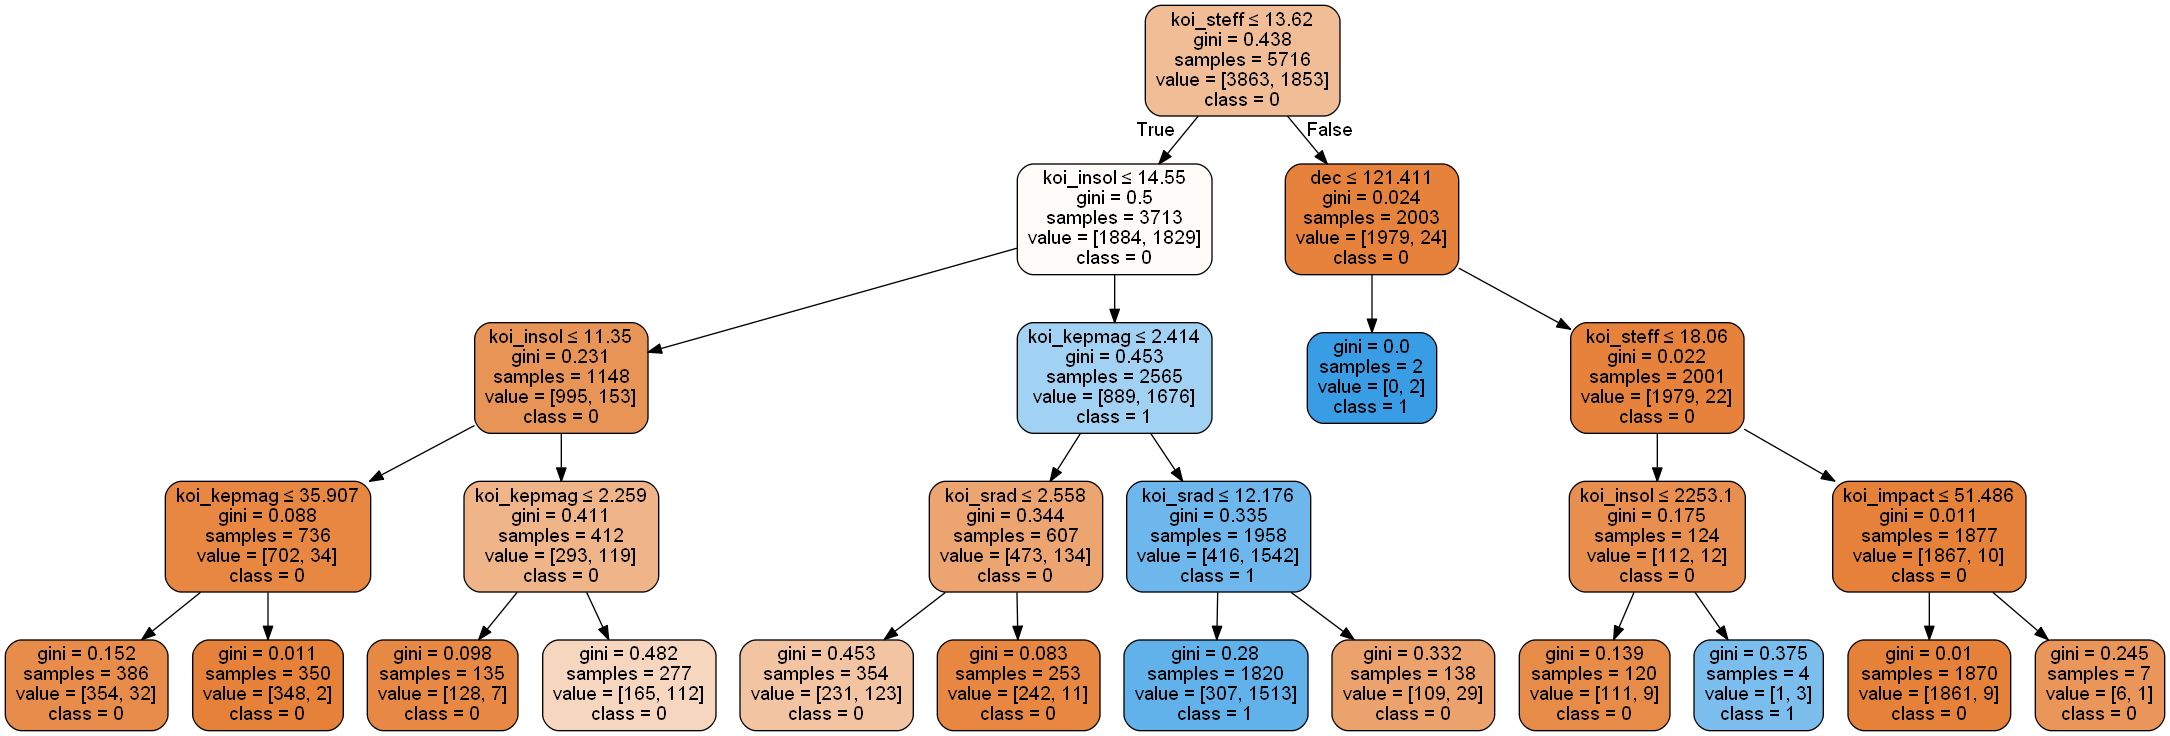

In [38]:
dot_data = StringIO()
export_graphviz(tre4, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = df_exo_x, class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('disposition2.png')
Image(graph.create_png())

In [39]:
#look at confusion matrices and hitrates
cm = confusion_matrix(y_test,ypred3)
hr_dt = (cm[0,0]+cm[1,1])/1430
mse_dt = mean_squared_error(y_test, ypred3)
print(cm)
print('HitRate:', (cm[0,0]+cm[1,1])/1430)
cm2 = confusion_matrix(y_test,ypred4)
print(cm2)
print('HitRate:', (cm2[0,0]+cm2[1,1])/1430)

[[901  76]
 [ 79 374]]
HitRate: 0.8916083916083916
[[887  90]
 [ 98 355]]
HitRate: 0.8685314685314686


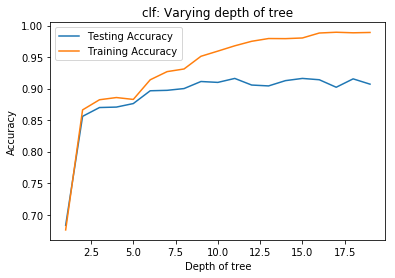

In [40]:
# Look at accuracies depending on depth for Random Forest

# Setup arrays to store train and test accuracies
dep = np.arange(1, 20)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = RandomForestClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [41]:
#random forest models

model = RandomForestClassifier(n_estimators = 100,max_depth=13, bootstrap=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# The mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test, y_pred)
print('R-Squared:', r2)

cm= confusion_matrix(y_test,y_pred)
print(cm)
print('HitRate:', (cm[0,0]+cm[1,1])/1430)

Mean squared error: 0.07902097902097902
R-Squared: 0.6348916921422294
[[918  59]
 [ 54 399]]
HitRate: 0.920979020979021


In [42]:
model = RandomForestClassifier(n_estimators = 100,max_depth=8, bootstrap=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# The mean squared error
mse_rf = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test, y_pred)
print('R-Squared:', r2)

cm= confusion_matrix(y_test,y_pred)
hr_rf = (cm[0,0]+cm[1,1])/1430
print(cm)
print('HitRate:', (cm[0,0]+cm[1,1])/1430)

Mean squared error: 0.07902097902097902
R-Squared: 0.5702707526983761
[[899  78]
 [ 55 398]]
HitRate: 0.906993006993007


In [43]:
#logistic regression models

model = LogisticRegression().fit(preprocessing.scale(X_train),y_train)
y_pred = model.predict(preprocessing.scale(X_test))

mse_log = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test, y_pred)
print('R-Squared:', r2)

cm= confusion_matrix(y_test,y_pred)
hr_log = (cm[0,0]+cm[1,1])/1430
print(cm)
print('HitRate:', (cm[0,0]+cm[1,1])/1430)

Mean squared error: 0.07902097902097902
R-Squared: 0.28593861914542207
[[842 135]
 [ 86 367]]
HitRate: 0.8454545454545455


##Compare Models

In [44]:
models = pd.DataFrame()
models['mod'] = ['Logistic','DicisionTree','RandomForest']
models['HitRate'] = [hr_log,hr_dt,hr_rf]
models['mse'] = [mse_log,mse_dt,mse_rf]

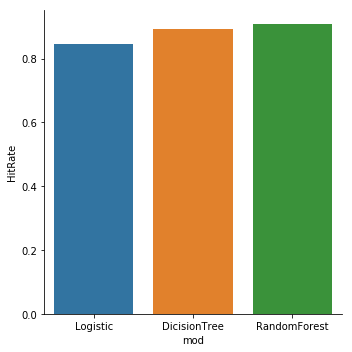

In [45]:
sns.catplot(x ='mod', y = 'HitRate', data = models, kind = 'bar')

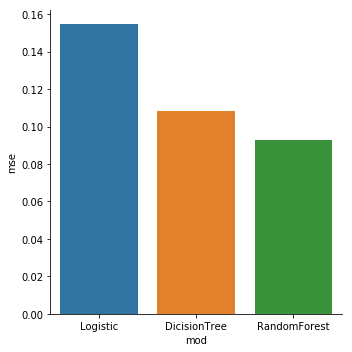

In [46]:
sns.catplot(x ='mod', y = 'mse', data = models, kind = 'bar')

##Fine Tuning

In [47]:
#Take out low varance varables
df2 = pd.concat([target,df[variable]],axis = 1)
d2 = df2.drop(columns='Confirmed')
X_train2, X_test2, y_train2, y_test2 = train_test_split(d2, df2['Confirmed'], test_size=0.2, random_state=9)

In [48]:
model = RandomForestClassifier(n_estimators = 100,max_depth=8, bootstrap=True)
model.fit(X_train2, y_train2)

y_pred = model.predict(X_test2)
# The mean squared error
mse = mean_squared_error(y_test2, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test2, y_pred)
print('R-Squared:', r2)

cm= confusion_matrix(y_test2,y_pred)
print(cm)
print('HitRate:', (cm[0,0]+cm[1,1])/1430)

Mean squared error: 0.09230769230769231
R-Squared: 0.5735017996705688
[[902  75]
 [ 57 396]]
HitRate: 0.9076923076923077


In [49]:
#doesn't effect hitrate but reduces dimensionality and mse!

In [50]:
#remove multicollinearity:
#koi_srad, koi_insol 0.579
#koi_model_snr, koi_depth 0.56
#koi_prad, koi_impact 0.6798
d2.corr()

koi_kepmag       dec        ra  koi_srad  koi_steff  \
koi_kepmag       1.000000  0.019343 -0.003774 -0.167432  -0.316073   
dec              0.019343  1.000000 -0.008342 -0.027745  -0.022297   
ra              -0.003774 -0.008342  1.000000  0.056984   0.108939   
koi_srad        -0.167432 -0.027745  0.056984  1.000000  -0.124206   
koi_steff       -0.316073 -0.022297  0.108939 -0.124206   1.000000   
koi_model_snr   -0.121788  0.004168  0.036769 -0.014585   0.151530   
koi_insol       -0.075080 -0.015382  0.029599  0.579243  -0.066178   
koi_teq         -0.262190 -0.056365  0.135015  0.485279   0.244907   
koi_prad        -0.021157 -0.003616  0.003482  0.058437  -0.013311   
koi_depth        0.051990 -0.014103  0.026162 -0.021893   0.120185   
koi_duration    -0.097122 -0.028712  0.036842  0.007743   0.088089   
koi_impact      -0.008757 -0.011718  0.012769  0.021813   0.018618   
koi_time0bk      0.010347 -0.015322 -0.048609 -0.012081   0.004846   

               koi_model_snr  koi_insol   koi_teq  koi_prad  koi_depth  \
koi_kepmag         -0.121788  -0.075080 -0.262190 -0.021157   0.051990   
dec                 0.004168  -0.015382 -0.056365 -0.003616  -0.014103   
ra                  0.036769   0.029599  0.135015  0.003482   0.026162   
koi_srad           -0.014585   0.579243  0.485279  0.058437  -0.021893   
koi_steff           0.151530  -0.066178  0.244907 -0.013311   0.120185   
koi_model_snr       1.000000  -0.012457  0.017578 -0.002562   0.568856   
koi_insol          -0.012457   1.000000  0.443474  0.003154  -0.010282   
koi_teq             0.017578   0.443474  1.000000 -0.002390   0.056693   
koi_prad           -0.002562   0.003154 -0.002390  1.000000   0.002030   
koi_depth           0.568856  -0.010282  0.056693  0.002030   1.000000   
koi_duration        0.079955  -0.020958 -0.190722  0.042690   0.062677   
koi_impact         -0.004479  -0.004820 -0.016436  0.679805   0.002787   
koi_time0bk        -0.053807  -0.023045 -0.303542  0.040525  -0.045881   

               koi_duration  koi_impact  koi_time0bk  
koi_kepmag        -0.097122   -0.008757     0.010347  
dec               -0.028712   -0.011718    -0.015322  
ra                 0.036842    0.012769    -0.048609  
koi_srad           0.007743    0.021813    -0.012081  
koi_steff          0.088089    0.018618     0.004846  
koi_model_snr      0.079955   -0.004479    -0.053807  
koi_insol         -0.020958   -0.004820    -0.023045  
koi_teq           -0.190722   -0.016436    -0.303542  
koi_prad           0.042690    0.679805     0.040525  
koi_depth          0.062677    0.002787    -0.045881  
koi_duration       1.000000    0.047162     0.195309  
koi_impact         0.047162    1.000000     0.061281  
koi_time0bk        0.195309    0.061281     1.000000

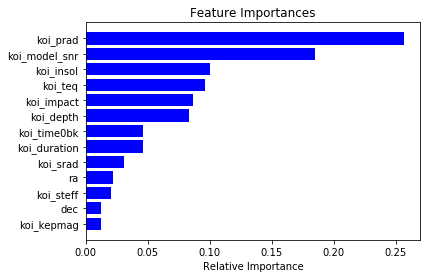

In [51]:
#plot feature importance
features = X_train2.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [52]:
#remove koi_impact because it has highest collinearity and lower feature
#importance than koi_prad

df3 = df2.drop(columns = 'koi_impact')
d3 = df3.drop(columns='Confirmed')
X_train3, X_test3, y_train3, y_test3 = train_test_split(d3, df3['Confirmed'], test_size=0.2, random_state=9)

In [53]:
model_final = RandomForestClassifier(n_estimators = 100,max_depth=8, bootstrap=True)
model_final.fit(X_train3, y_train3)

y_pred = model_final.predict(X_test3)
# The mean squared error
mse = mean_squared_error(y_test3, y_pred)
print('Mean squared error:', mse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_test3, y_pred)
print('R-Squared:', r2)

cm= confusion_matrix(y_test3,y_pred)
print(cm)
print('HitRate:', (cm[0,0]+cm[1,1])/1430)

Mean squared error: 0.0972027972027972
R-Squared: 0.5508844708652202
[[901  76]
 [ 63 390]]
HitRate: 0.9027972027972028


In [54]:
#Reduced HitRate a little, but worth it to reduce multicollinearity

In [55]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix CM1', cmap=plt.cm.Purples):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

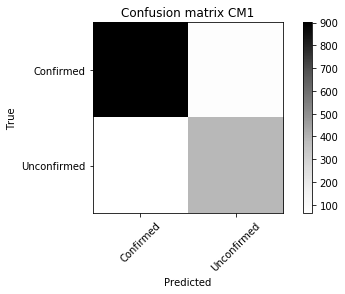

In [56]:
plot_confusion_matrix(cm, classes=["Confirmed", "Unconfirmed"], cmap=plt.cm.Greys)
plt.show()

In [57]:

estimator = model_final.estimators_[1]

#from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_test3.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')